In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Example system

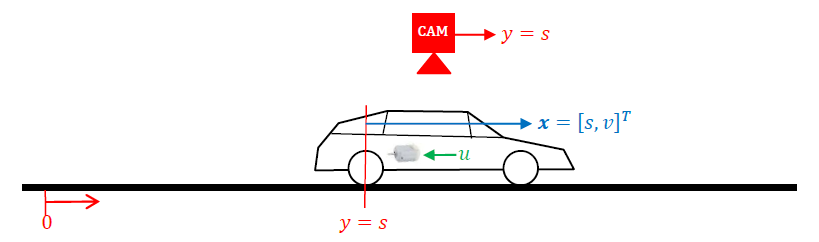

State space equations:

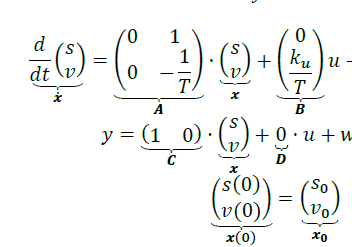

In [2]:
T = 0.300 # s 
ku = 2.51 # m/s

In [3]:
A = np.asarray([[0, 1], 
                [0, -1/T]])

In [4]:
B = np.asarray([[0], 
                [ku/T]])

In [5]:
C = np.array([1, 0])

In [6]:
D = 0

## Initial conditions

In [7]:
x0 = np.array([[0], [0]])

In [8]:
x0

array([[0],
       [0]])

# Simulation of cont. LTI state-space

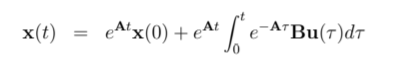

from http://web.mit.edu/2.14/www/Handouts/StateSpaceResponse.pdf (Derek Rowell, MIT, 2002)

In [9]:
from scipy.linalg import expm
from sympy import Symbol, Matrix, integrate, MatMul
import sympy as sp
from sympy import symbols

## Symbolic integration

The following cells use `sympy` to create a symbolic integral.

In [10]:
tau_symbol = Symbol("\tau")
t_symbol = Symbol("t")
integral_0_t = integrate(MatMul(sp.exp(-Matrix(A)*tau_symbol), Matrix(B)), (tau_symbol, 0, t_symbol))

In [11]:
integral_0_t

Matrix([
[2.51*t - 0.753*exp(3.33333333333333*t) + 0.753],
[           2.51*exp(3.33333333333333*t) - 2.51]])

Time vector for calculation:

In [12]:
TA_cont = 1e-3 # point in time for cont. calculation
T_end = 10

In [13]:
t_continuous = np.arange(0, T_end, TA_cont)

In [14]:
u_k = 1*np.ones_like(t_continuous) # step function input

In [15]:
def calculate_x(t):
    integral_value = np.array(integral_0_t.subs(t_symbol, t)).astype(np.float64)
    return expm(A*t) @ x0 + expm(A*t) @ integral_value

In [16]:
x_continuous = np.zeros((2, t_continuous.size))

In [17]:
for i in tqdm(range(t_continuous.size)):
    x_continuous[:, i] = calculate_x(t_continuous[i]).reshape((2,))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 518.98it/s]


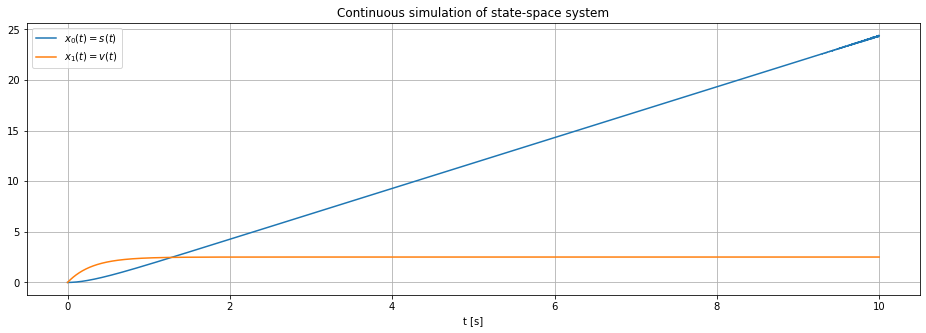

In [18]:
plt.figure(figsize=(16, 5))
plt.plot(t_continuous, x_continuous[0, :], label="$x_0(t)=s(t)$")
plt.plot(t_continuous, x_continuous[1, :], label="$x_1(t)=v(t)$")
plt.grid()
plt.legend()
plt.xlabel("t [s]")
plt.title("Continuous simulation of state-space system");

# Discretization

In [19]:
# sample time
TA = 0.1  # s


## Literature (Marchtaler)

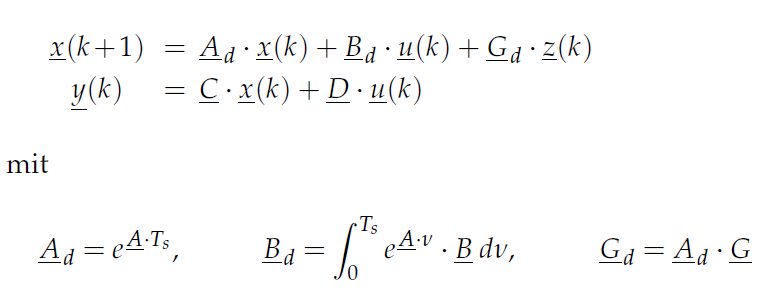

In [20]:
from scipy.linalg import expm

In [21]:
Ad = expm(A*TA)
Ad

array([[1.        , 0.08504061],
       [0.        , 0.71653131]])

In [22]:
v = Symbol("v")
Bd = np.asarray(integrate(MatMul(sp.exp(Matrix(A*v)), Matrix(B)), (v, 0, TA)), dtype=np.float64)
Bd

array([[0.03754808],
       [0.71150641]])

In [23]:
t_discrete = np.arange(0, T_end, TA)

In [24]:
x_marchtaler = np.zeros((2, t_discrete.size))

In [25]:
N = t_discrete.size

In [26]:
# set x(0)
x_marchtaler[:, 0] = x0.reshape((2,))

In [27]:
Ad @ x_marchtaler[:, 0:1]

array([[0.],
       [0.]])

In [28]:
for k in range(1, N, 1):
    x_k = Ad @ x_marchtaler[:, k-1].reshape((2,1)) + Bd # with 1=u(k) = 1
    x_marchtaler[:, k] =  x_k.reshape((2,))

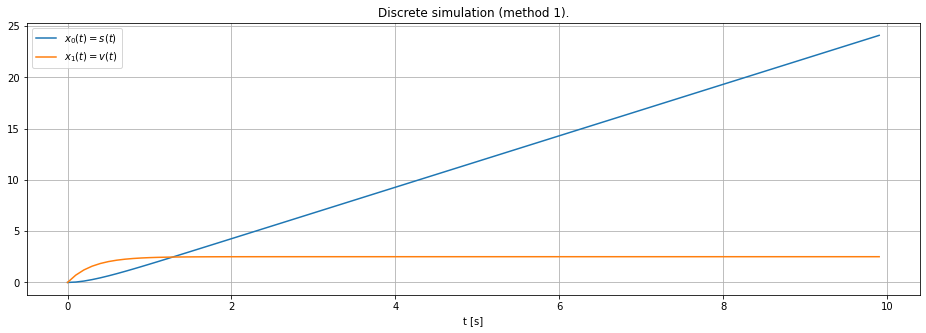

In [29]:
plt.figure(figsize=(16, 5))
plt.plot(t_discrete, x_marchtaler[0, :], label="$x_0(t)=s(t)$")
plt.plot(t_discrete, x_marchtaler[1, :], label="$x_1(t)=v(t)$")
plt.grid()
plt.legend()
plt.xlabel("t [s]")
plt.title("Discrete simulation (method 1).");


## Backward Euler

Via Backward Euler method, see https://en.wikipedia.org/wiki/Backward_Euler_method

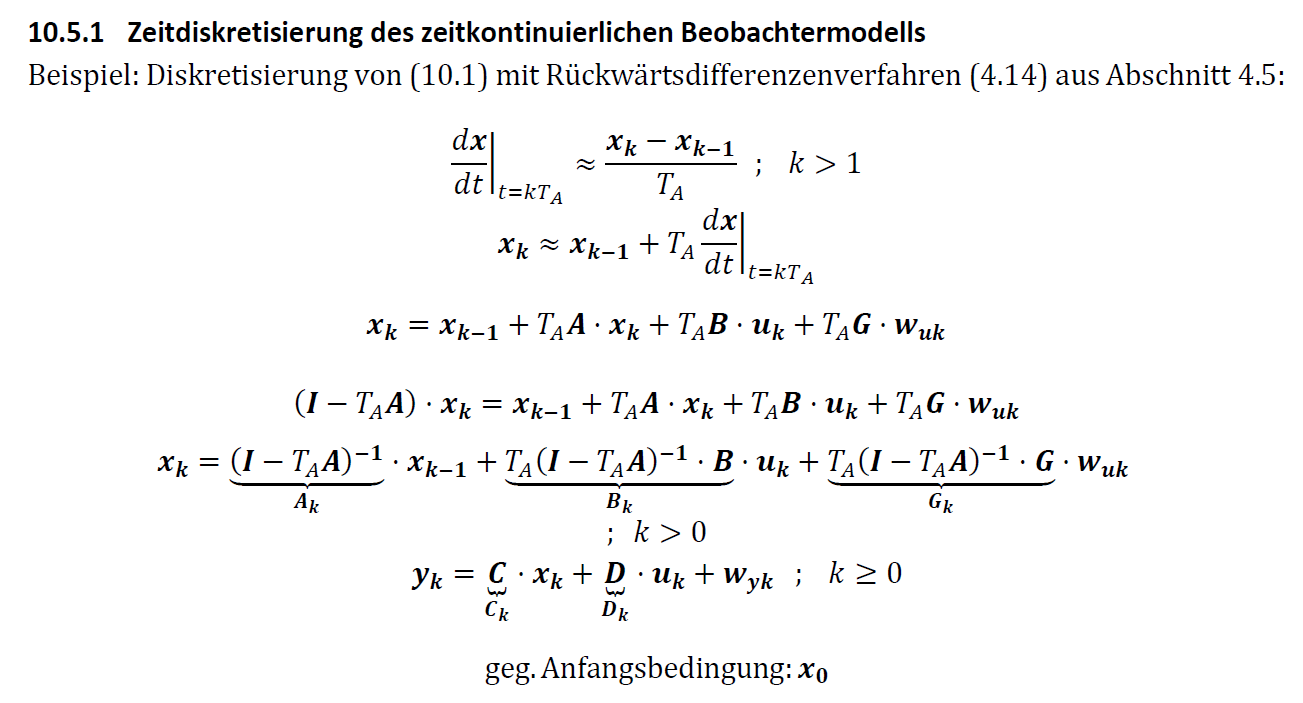

In [30]:
from scipy.linalg import inv

In [31]:
Ak = inv(np.eye(2) - TA*A)
Ak

array([[1.   , 0.075],
       [0.   , 0.75 ]])

In [32]:
Bk = TA*Ak @ B
Bk

array([[0.06275],
       [0.6275 ]])

In [33]:
x_backward = np.zeros((2, t_discrete.size))

In [34]:
# set x(0)
x_backward[:, 0] = x0.reshape((2,))

In [35]:
for k in range(1, N, 1):
    x_k = Ak @ x_backward[:, k-1].reshape((2,1)) + Bk # with 1=u(k) = 1
    x_backward[:, k] =  x_k.reshape((2,))

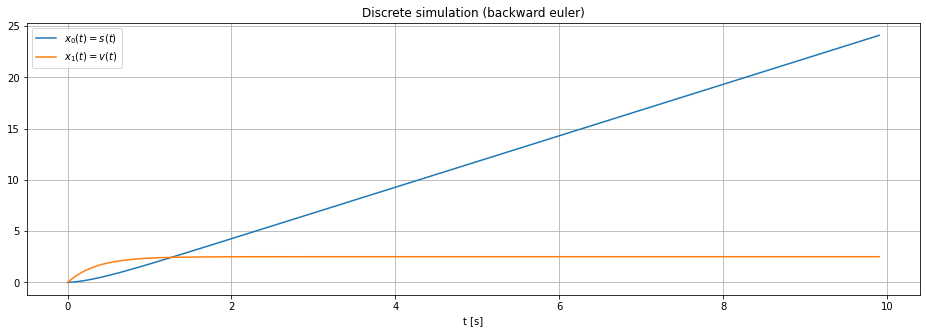

In [36]:
plt.figure(figsize=(16, 5))
plt.plot(t_discrete, x_backward[0, :], label="$x_0(t)=s(t)$")
plt.plot(t_discrete, x_backward[1, :], label="$x_1(t)=v(t)$")
plt.grid()
plt.legend()
plt.xlabel("t [s]")
plt.title("Discrete simulation (backward euler)");

## Trapezoidal integration

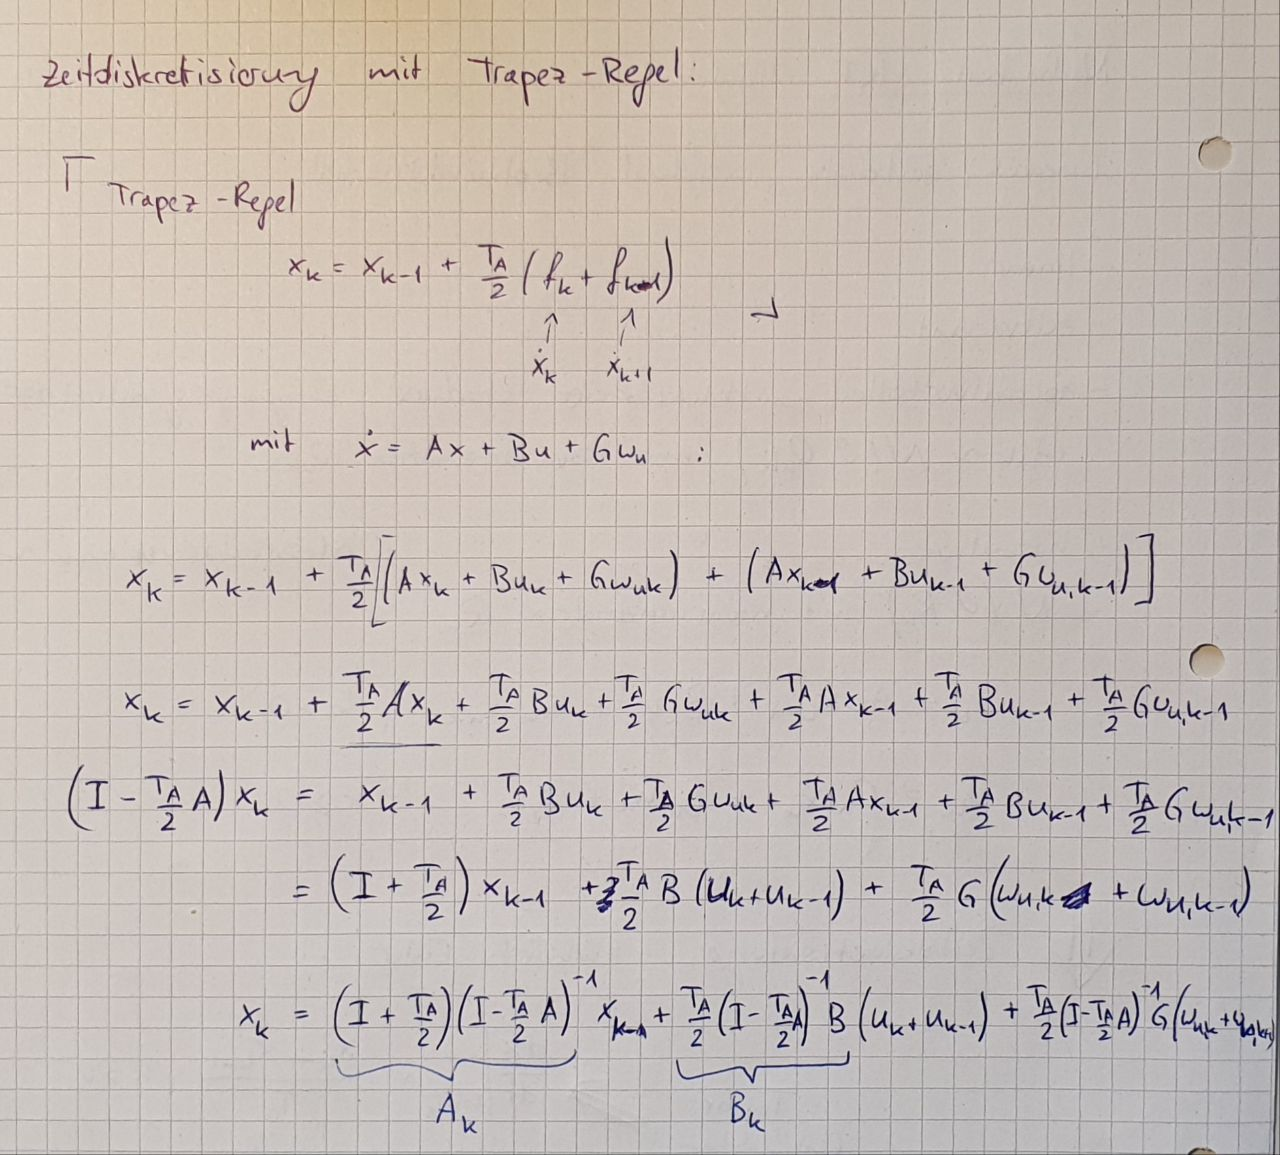

In [37]:
Ak = inv(np.eye(2) - TA*A/2) @ (np.eye(2) + TA/2)

In [38]:
Bk = inv(np.eye(2) - TA*A/2)*TA/2 @ B

In [39]:
x_trapez = np.zeros((2, t_discrete.size))

In [40]:
# set x(0)
x_trapez[:, 0] = x0.reshape((2,))

In [41]:
for k in range(1, N, 1):
    x_k = Ak @ x_trapez[:, k-1].reshape((2,1)) + Bk*2# with 1=u(k) = 1
    x_trapez[:, k] =  x_k.reshape((2,))

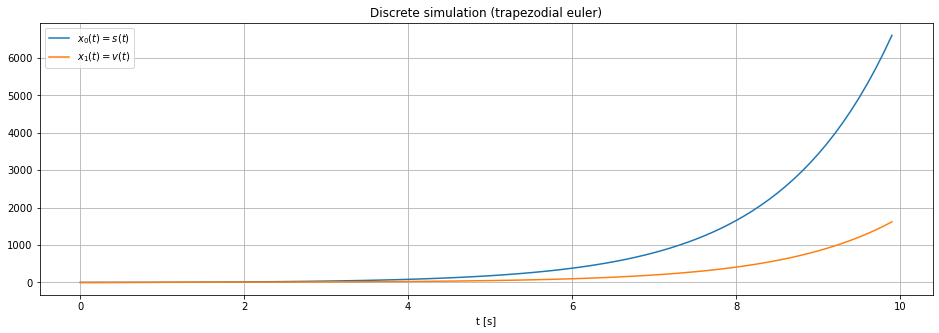

In [42]:
plt.figure(figsize=(16, 5))
plt.plot(t_discrete, x_trapez[0, :], label="$x_0(t)=s(t)$")
plt.plot(t_discrete, x_trapez[1, :], label="$x_1(t)=v(t)$")
plt.grid()
plt.legend()
plt.xlabel("t [s]")
plt.title("Discrete simulation (trapezodial euler)");